# Analysing lung cells from aging mice with scllm

## Summary

In this code, we analyze single-cell RNA sequencing data using the `scanpy` library and a language model for annotation. We start by loading our dataset and then use a pre-trained language model to annotate factors based on principal component analysis (PCA) results. We visualize these factors with strip plots and embeddings. Next, we compute neighborhood relationships and identify clusters using the Leiden algorithm. We further annotate these clusters with cell type information using the language model and visualize the results through embeddings and heatmaps. This workflow allows us to gain insights into the cellular composition and characteristics of our dataset.

## Setup

In this section, we set up our environment to work with the `scllm` library and the Angelidis et al. dataset. First, we load our API key for ChatGPT using `dotenv`, which allows us to keep our credentials secure and separate from our code. Then, we import necessary libraries: `scllm` for single-cell analysis, `scanpy` for handling our scRNA-seq data, `pandas` for data manipulation, and `matplotlib` for plotting. 

Next, we read the Angelidis dataset from an HDF5 file using `sc.read_h5ad()`, which loads our single-cell data into an AnnData object. This sets the stage for further analysis, such as annotating factors and clusters in the dataset.

In [ ]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv("../../../../.env")
import scllm as sl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from langchain_openai import ChatOpenAI

In these lines, we set up the OpenAI model that we'll use for our analysis. The variable `openai_model` is assigned the string `"gpt-4o-mini"`, which specifies the version of the model we want to use. Then, we create an instance of `ChatOpenAI` called `llm`, where we set the `temperature` to `0.0`. This means we want the model to generate consistent and deterministic outputs, rather than random or creative ones. This is crucial for tasks like annotating factors and clusters in our single-cell RNA-seq dataset, as we want reliable and reproducible results. Essentially, this setup allows us to leverage the power of the OpenAI model for our computational biology tasks.

In [5]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

## Data preprocessing

We start by loading the Angelidis dataset, which is a complex single-cell RNA-seq dataset containing over 20 different cell types from mouse lung tissue. This dataset is already preprocessed and includes a precomputed PCA, making our analysis easier.

The line `angelidis = sc.read_h5ad('/Users/harald/Downloads/angelidis.h5ad')` reads the dataset from an H5AD file into an AnnData object, which is a convenient format for handling single-cell data in Python. This object allows us to access the expression data, metadata, and precomputed PCA results efficiently. With this setup, we can proceed to annotate factors and clusters, leveraging the power of the `scllm` library and the ChatGPT model for insightful biological interpretations.

In [ ]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/angelidis.h5ad')

In this snippet, we use `sl.tl.annotate_factor` to identify cell types based on the first principal components (PCs) from our scRNA-seq data. By default, this function queries for cell types, which is crucial since the first components often represent distinct cell types. We set `top_genes=50` to focus on the top 50 genes contributing to each factor, and `num_samples=10` tells the function to query these genes 10 times. Scllm then extracts the most likely term for each factor, giving us a clearer understanding of the underlying biology. This step is essential for annotating our dataset and helps us interpret the cellular diversity in the lung tissue from the Angelidis et al. study.

In [ ]:
sl.tl.annotate_factor(
    angelidis,
    varm_key='PCs',
    llm=llm,
    top_genes=50,
    num_samples=10
)

In this part of the script, we create a factor strip plot using `sl.pl.factor_stripplot`. This visualization helps us get an overview of the major axes of variation in our single-cell RNA-seq dataset. The factors we’re plotting (0 to 5) are likely driven by differences across cell types, which is crucial for understanding the biological context of our data.

We specify the `obsm_key='X_pca'` to use the PCA coordinates for our plot, and `annotation_key='factor_annotation'` to label the points based on their factor annotations. The `size` and `jitter` parameters help us adjust the appearance of the points, making it easier to see the distribution. By plotting these factors, we can quickly identify how different cell types contribute to the overall variation in the dataset.

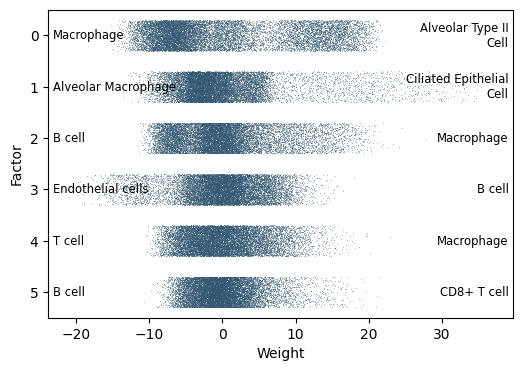

In [14]:
plt.figure(figsize=(6, 4))
sl.pl.factor_stripplot(
    angelidis,
    factors=['0', '1', '2', '3', '4', '5'],
    obsm_key='X_pca',
    annotation_key='factor_annotation',
    size=.4,
    jitter=.3,
    ax=plt.gca()
)

In this snippet, we use `sl.pl.factor_embedding` to overlay UMAP plots with factor weights derived from our PCA analysis. By specifying `obsm_key='X_pca'`, we’re telling the function to use the PCA coordinates for our cells. The `factors` parameter includes the top factors we identified earlier, which represent important features in our dataset. 

Overlaying these factors on the UMAP allows us to visualize how different cell populations relate to these key features, helping us understand the underlying biology better. The `annotation_key='factor_annotation'` links our factors to meaningful biological interpretations, making it easier to see how they influence cell distribution in the UMAP space. The `ncols=2` just organizes our plots into two columns for better readability.

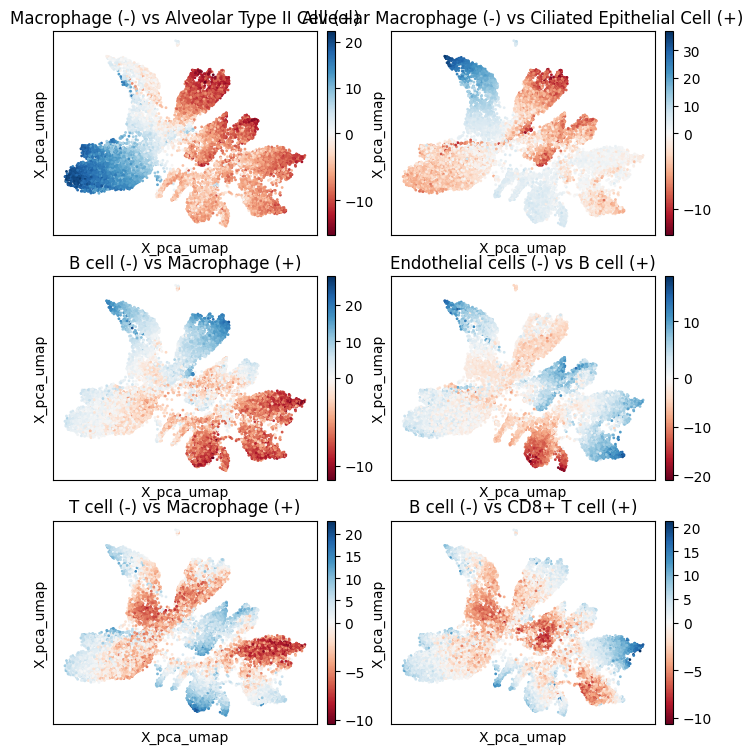

In [ ]:
_ = sl.pl.factor_embedding(
    angelidis,
    obsm_key='X_pca',
    factors=['0', '1', '2', '3', '4', '5'],
    basis='X_pca_umap',
    annotation_key='factor_annotation',
    ncols=2,
)

## Annotating cell types

In this part of the script, we first call `sc.pp.neighbors(angelidis)`, which computes the neighborhood graph of the cells based on their PCA embeddings. This step is crucial because it helps us understand how cells are related to each other in the high-dimensional space. Next, we use `sc.tl.leiden(angelidis)` to perform community detection using the Leiden algorithm, which identifies clusters of similar cells. These clusters represent different cell types or states within our dataset. By doing this, we set the stage for further analysis and annotation of these clusters, allowing us to assign meaningful biological identities to the cell populations we’ve identified.

In [15]:
sc.pp.neighbors(angelidis)
sc.tl.leiden(angelidis)

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_58649/144542317.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(angelidis)


In this part of the script, we want to inspect the clusters we've identified in our single-cell RNA-seq data. The line `sc.pl.embedding(angelidis, basis="X_pca_umap", color='leiden')` visualizes these clusters using the UMAP representation of our PCA results, coloring the points by their cluster assignments from the Leiden algorithm.

Next, we aim to annotate the cell types within these clusters. The line `sl.tl.annotate_cluster(angelidis, cluster_key='leiden', llm=llm, num_samples=5, key_added="cell_types_1")` uses the `scllm` library to automatically assign cell type annotations to each cluster based on the Leiden labels. We specify that we want 5 samples for the annotation, and the results will be stored under the key "cell_types_1". This helps us understand the biological significance of the clusters we've visualized.

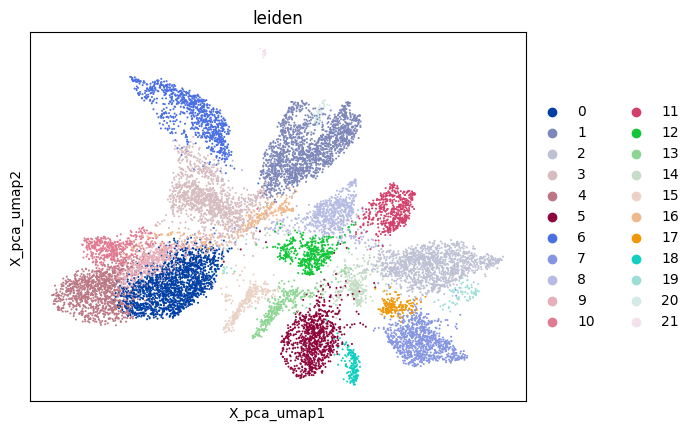

In [18]:
sc.pl.embedding(angelidis, basis="X_pca_umap", color='leiden')

In this part of the script, we use the `sl.tl.annotate_cluster` function to assign cell type annotations to the clusters identified in our scRNA-seq dataset. We specify the `cluster_key` as 'leiden', which refers to the clustering results we obtained earlier. The `llm` parameter is our language model, which helps generate meaningful annotations based on the cluster characteristics. We set `num_samples` to 5, meaning we want five different annotations for each cluster, and we store the results in a new key called "cell_types_1". This step is crucial as it helps us interpret the biological significance of the clusters, giving us insights into the different cell types present in the lung tissue from the Angelidis dataset.

In [20]:
sl.tl.annotate_cluster(
    angelidis,
    cluster_key='leiden',
    llm=llm,
    num_samples=5,
    key_added="cell_types_1"
)

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.

In this part of the script, we’re visualizing the results of our cell type annotations on the UMAP embedding of the single-cell RNA-seq data. The line `sc.pl.embedding(angelidis, basis="X_pca_umap", color='cell_types_1')` generates a plot where each point represents a single cell, colored according to the cell types we just annotated using the `sl.tl.annotate_cluster` function. This helps us see how well our clustering aligns with the identified cell types, giving us insights into the cellular composition of the lung tissue. Essentially, we’re making it easier to interpret our data by visually representing the different cell types in a meaningful way.

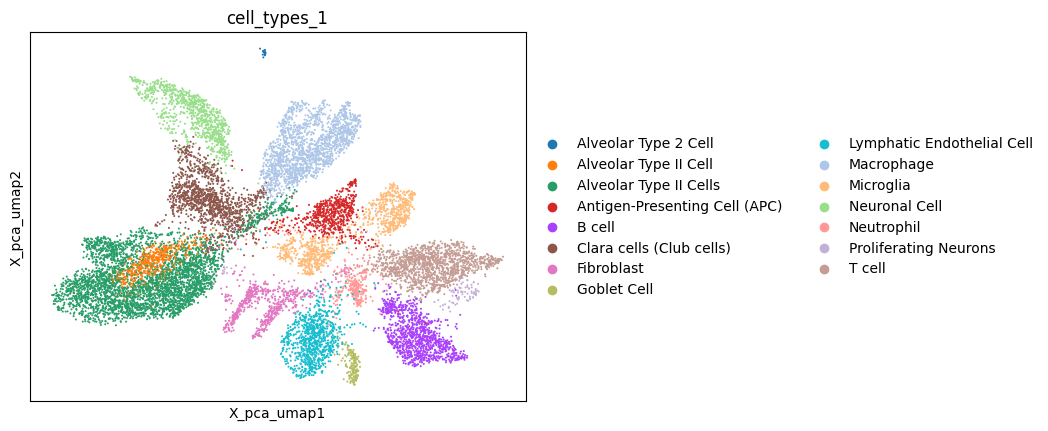

In [21]:
sc.pl.embedding(angelidis, basis="X_pca_umap", color='cell_types_1')

In this part of the code, we’re generating a heatmap to visualize the expression of genes across different cell types identified in our single-cell RNA-seq dataset. We use `sc.pl.heatmap()` from the Scanpy library, where we specify `groupby="cell_types_1"` to group our data by the cell types we annotated earlier using the `scllm` package. The `var_names=angelidis.uns['cell_types_1']['var_names']` argument pulls the specific genes associated with those cell types from the results stored in the AnnData object. This heatmap helps us quickly see which genes are upregulated or downregulated in each cell type, giving us insights into their functional roles in the lung tissue.

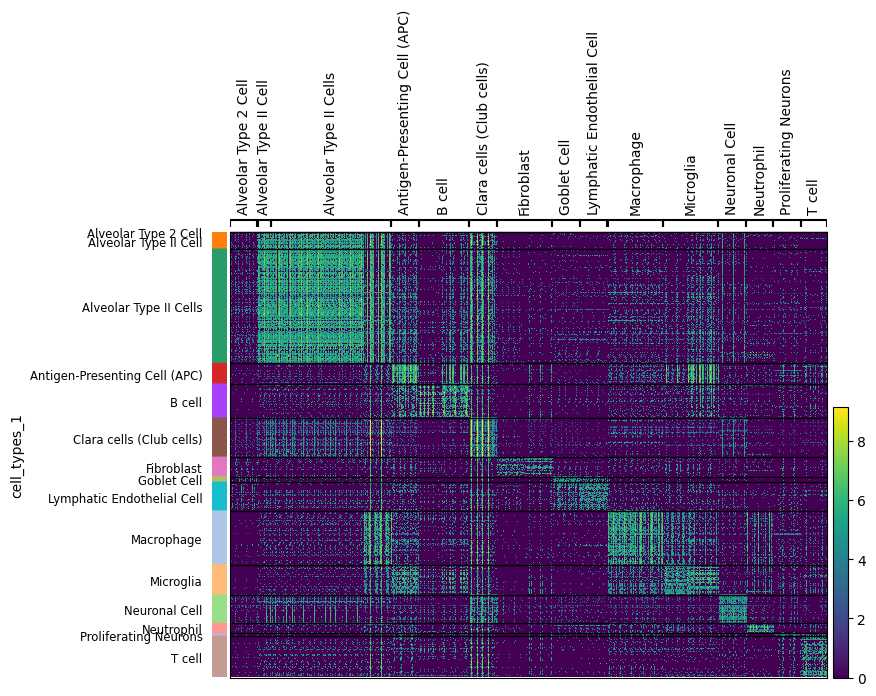

In [29]:
sc.pl.heatmap(angelidis, groupby="cell_types_1", var_names=angelidis.uns['cell_types_1']['var_names'])

In this script, we start by loading the Angelidis dataset, which contains single-cell RNA-seq data from mouse lung tissue. We use `scllm` to annotate factors based on PCA results, pulling in the top 50 genes and generating 10 samples for better insights. Next, we visualize these factors with a strip plot and an embedding plot, helping us see how the cells cluster in PCA space.

Then, we compute the neighborhood graph and apply the Leiden algorithm to identify clusters in the data. After that, we annotate these clusters with cell type information using the LLM, adding this to our dataset. Finally, we visualize the clusters and their corresponding heatmap, giving us a clear view of gene expression patterns across the identified cell types.